Будет использоваться последовательная нейронная сеть Squental из билиотеки tensorflow.

Грузим библиотеки

In [1]:
pip install ctgan

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import ctgan
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn import metrics
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from ctgan import CTGAN
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

Загружаем датасет

In [3]:
iris = datasets.load_iris()

В этом датасете содержится информация о 3 различных видах ирисов и их параметров, всего 150 цветов, по 50 примеров на цветок соответственно.

Виды цветков:

Iris setosa

Iris versicolor

Iris virginica

Характеристики цветков:

Длина чашелистика (sepal length) в сантиметрах.
Ширина чашелистика (sepal width) в сантиметрах.
Длина лепестка (petal length) в сантиметрах.
Ширина лепестка (petal width) в сантиметрах.

**Генерируем синтетические данные для масштабирования исследования используя библиотеку CTGAN**

Берём отдельно данные по каждому виду цветка, генерируем значения в количестве 1000 штук для каждого цветка, соединяем в один массив и заменяем изначальные данные.

In [4]:
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target_names[iris.target]

# Выбор данных для каждого типа ириса
setosa = iris_df[iris_df['species'] == 'setosa']
versicolor = iris_df[iris_df['species'] == 'versicolor']
virginica = iris_df[iris_df['species'] == 'virginica']
#Создание модели нейросети
ctgan = CTGAN(
    epochs=50, # Эпохи обучения, тут главное не переобучить нейросеть
)
ColSamples = 1000
# Обучение модели на основе данных о setosa. Не забудем что должны убрать последнюю
#колонку, т.к. в ней содержится просто название цветка.
ctgan.fit(setosa.iloc[:,:-1])
# Генерация синтетических данных
setosa = ctgan.sample(ColSamples)
ctgan.fit(versicolor.iloc[:,:-1])
# Генерация синтетических данных
versicolor = ctgan.sample(ColSamples)
ctgan.fit(virginica.iloc[:,:-1])
# Генерация синтетических данных
virginica = ctgan.sample(ColSamples)

iris.data = np.concatenate((setosa, versicolor, virginica))

Создаем массив из такого же количества 0, 1 и 2. Так как по этим маркером будет определяться к какому виду принадлежат те или иные значения.

In [5]:
# Создание массива с ColSamples нулями
zeros = np.zeros(ColSamples, dtype=int)

# Создание массива с ColSamples единицами
ones = np.ones(ColSamples, dtype=int)

# Создание массива с ColSamples двойками
twos = np.full(ColSamples, 2, dtype=int)

# Объединение массивов в один
new_data = np.concatenate((zeros, ones, twos))
# Объединение существующего датасета с новыми данными
iris.target = new_data
# На всякий случай отсортируем
iris.target = np.sort(iris.target)

Создаём макет, с которым и будем работать в дальнейшем

In [6]:
iris_frame = DataFrame(iris.data)
# Делаем имена колонок такие же, как имена переменных:
iris_frame.columns = iris.feature_names
# Добавляем столбец с целевой переменной:
iris_frame['target'] = iris.target
# Для наглядности добавляем столбец с сортами:
iris_frame['name'] = iris_frame.target.apply(lambda x: iris.target_names[x])
# Смотрим, что получилось:
print(iris_frame)

      sepal length (cm)  sepal width (cm)  petal length (cm)  \
0              5.766077          4.147028           1.406493   
1              5.099257          3.707793           1.603229   
2              5.387856          3.682947           1.081522   
3              5.691603          3.558783           1.777022   
4              5.315707          3.368906           1.325255   
...                 ...               ...                ...   
2995           5.650138          2.776809           5.999979   
2996           8.471908          2.826758           7.239331   
2997           5.913539          2.933486           6.748731   
2998           7.012383          2.594084           7.543344   
2999           8.488302          2.564432           7.278632   

      petal width (cm)  target       name  
0             0.328704       0     setosa  
1             0.177340       0     setosa  
2             0.474584       0     setosa  
3             0.395769       0     setosa  
4          

Выведем график для оценки распределения данных

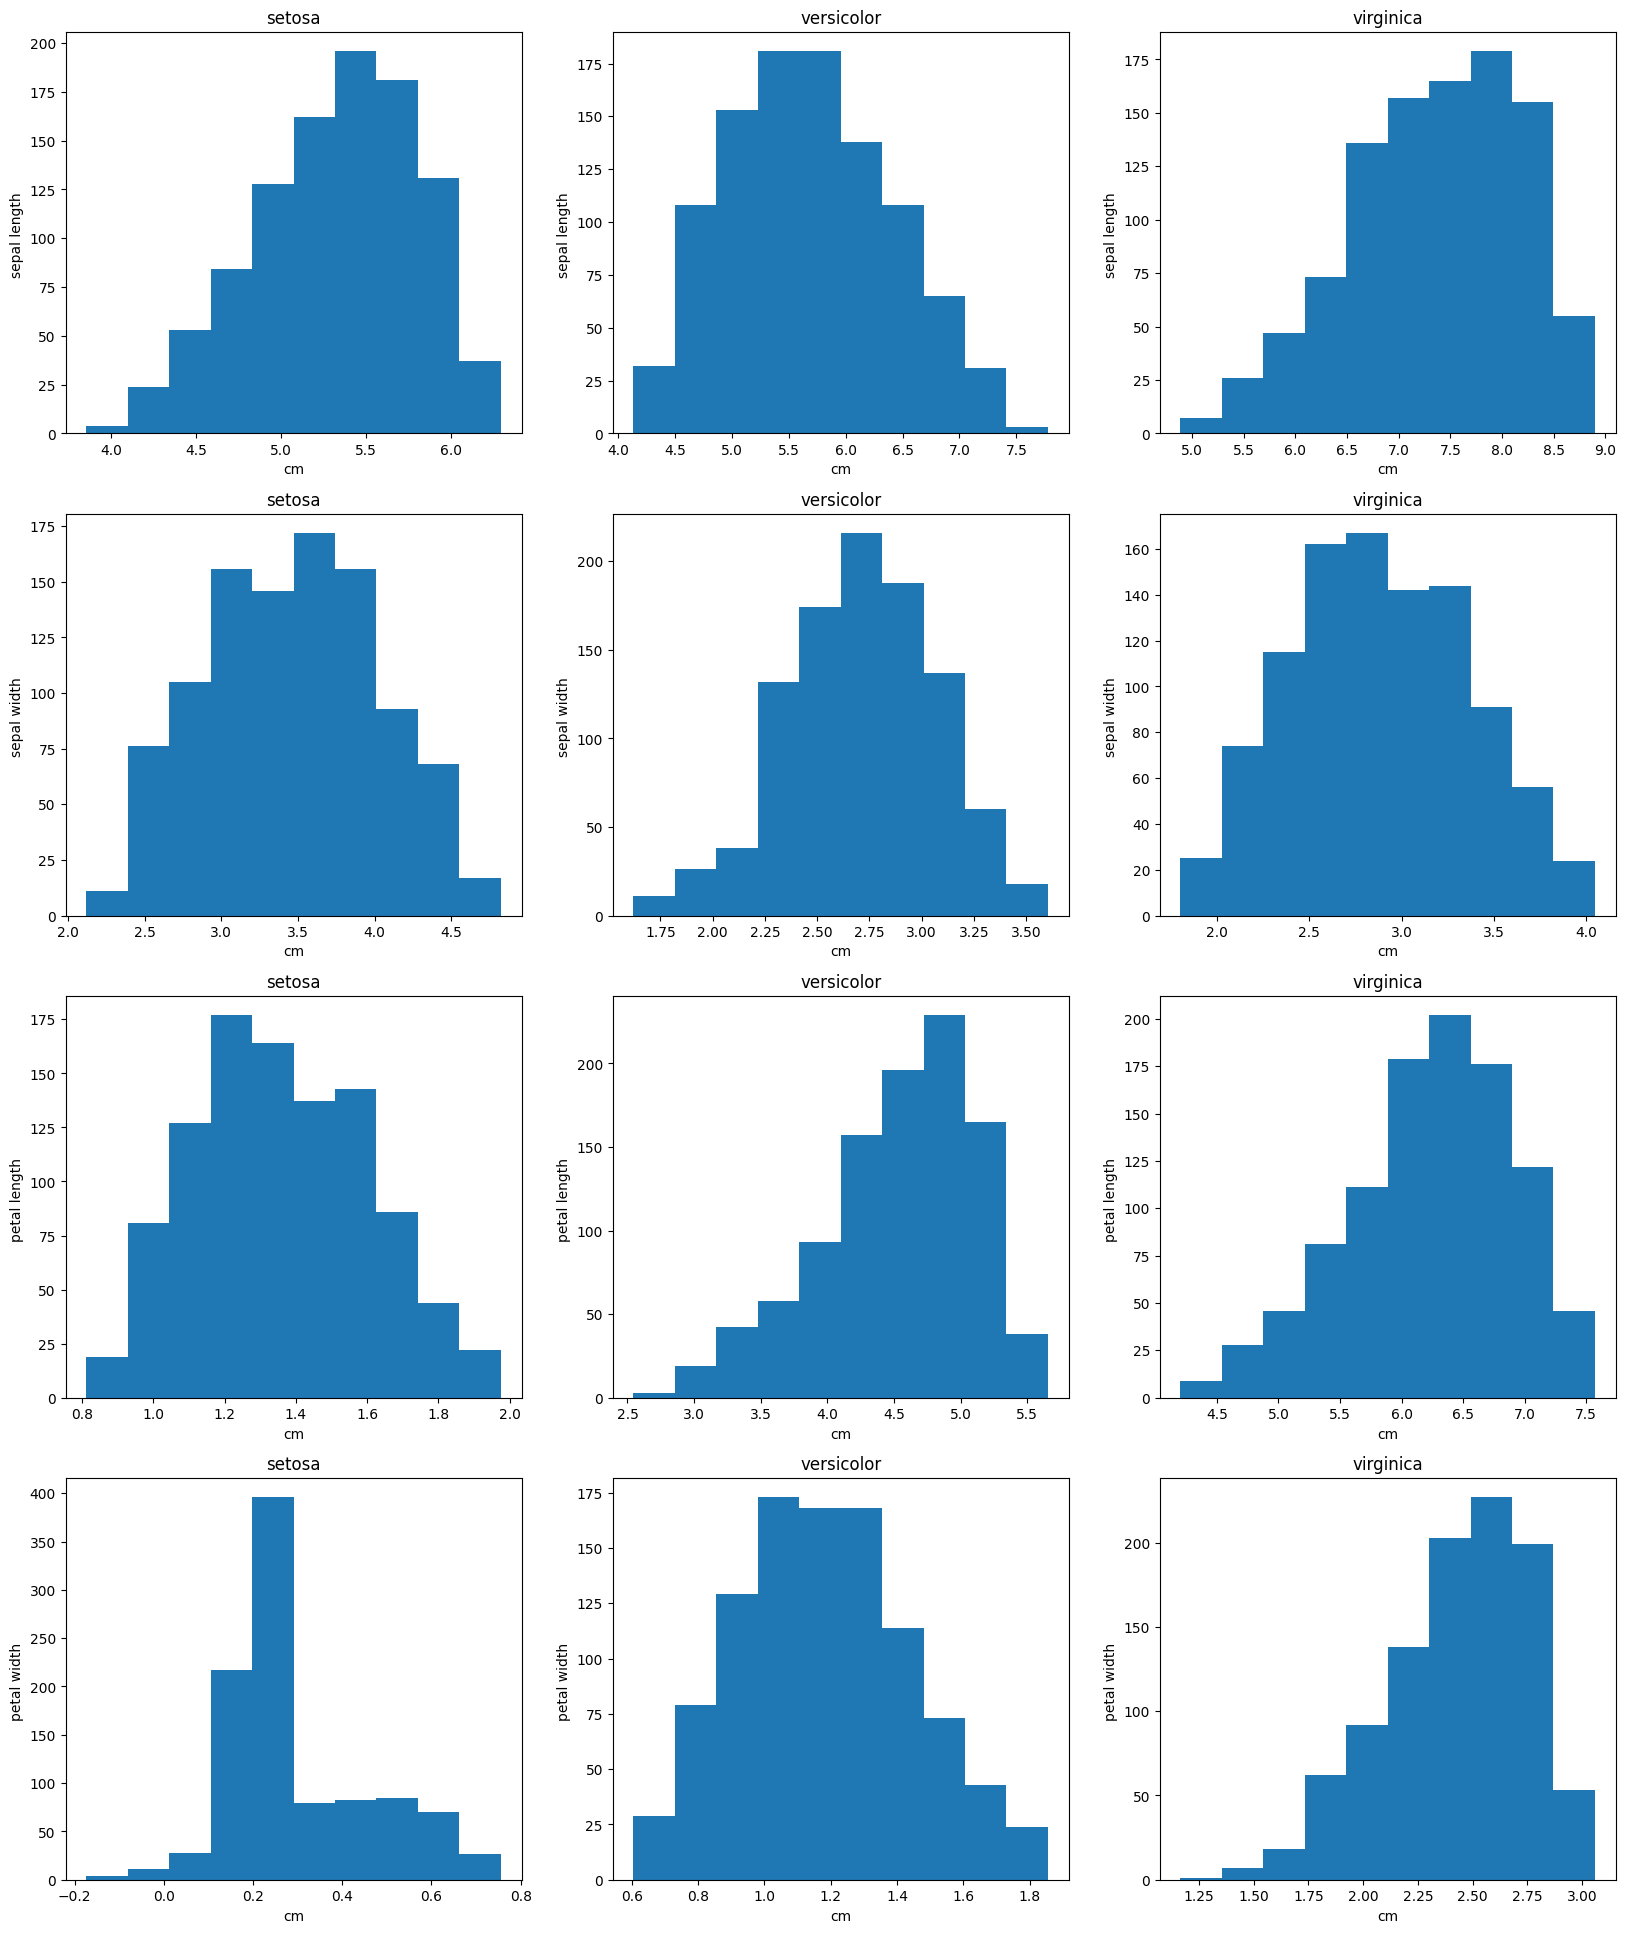

In [7]:
plt.figure(figsize=(20, 24))
plot_number = 0
for feature_name in iris['feature_names']:
    for target_name in iris['target_names']:
       plot_number += 1
       plt.subplot(4, 3, plot_number)
       plt.hist(iris_frame[iris_frame.name == target_name][feature_name])
       plt.title(target_name)
       plt.xlabel('cm')
       plt.ylabel(feature_name[:-4])
plt.show()

Для более наглядного результата построим таблицу зависимостей

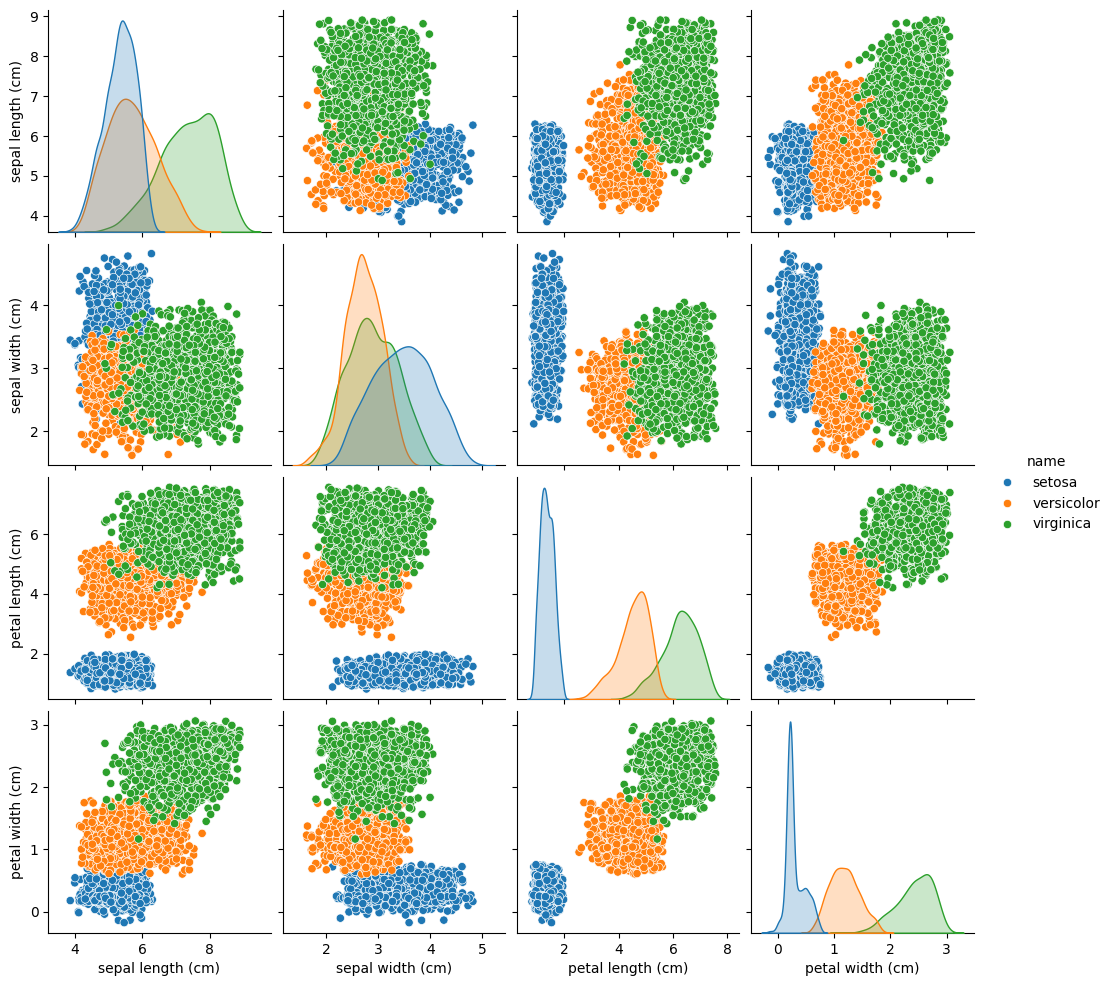

In [8]:
import seaborn as sns
sns.pairplot(iris_frame[['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)','name']], hue='name')
plt.show()

По этому графику можно сказать что значения petal length и petal width имеют очень хорошую корреляцию и их распределение похоже на нормальное.

Убедимся в верности суждений графически

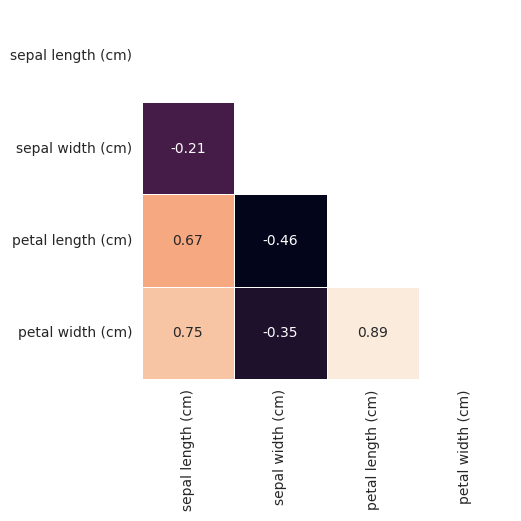

In [9]:
corr = iris_frame[['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
   ax = sns.heatmap(corr, mask=mask, square=True, cbar=False, annot=True, linewidths=.5)
plt.show()

Видим что коэффициент корреляции составляет 0.89 у petal length и petal width. Что является высоким значением.

Разбиваем данные для работы с моделью нейросети

In [10]:
train_data, test_data, train_labels, test_labels = train_test_split(
    iris_frame[['petal length (cm)', 'petal width (cm)']],
    iris_frame[['target']],
    test_size=0.3, #Это значение влияет на то какое количество данных пойдёт на
  # обучение модели, а какое на тестирование. соответсвенно на обучение 0.7 всех
  # данных, а 0.3 на тестирование, считаю это отношение оптимальным в этом случае

    random_state=0
)

Строим линию регрессии для наших данных

In [11]:
fit_output = stats.linregress(iris_frame[['petal length (cm)','petal width (cm)']])
slope, intercept, r_value, p_value, slope_std_error = fit_output
print(slope, intercept, r_value, p_value, slope_std_error)

0.3890624003543537 -0.2712970087123021 0.893599680443994 0.0 0.003569242000084863


**Создание и обучение нейросети**

In [12]:
#Создаём модель нейросети, задаём количество нейронов и т.п.
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(2,)),
    # первый слой содержит 64 нейрона, а входной input_shape 2(по количеству входных значений)
    tf.keras.layers.Dropout(0.1),
    #  Dropout - это метод регуляризации, который случайным образом удаляет некоторые нейроны в процессе обучения.
    #  Это помогает предотвратить переобучение модели, улучшая ее обобщающую способность.
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(3, activation='softmax')  # Выходной слой с 3 нейронами (по числу классов) и функцией активации softmax для многоклассовой классификации
])

# Компиляция модели
model.compile(optimizer='adam',  # Оптимизатор Adam это метод оптимизации, который сочетает в себе идеи метода
                                  #градиентного спуска с адаптивным шагом обучения и метода адаптивной оценки моментов.
              loss='sparse_categorical_crossentropy',  # Функция потерь для многоклассовой классификации
              metrics=['accuracy'])  # Метрика - точность классификации

# Обучение модели на train_data указываем количество эпох(50), главное не переобучить модель
history = model.fit(train_data, train_labels, epochs=50, batch_size=2, validation_split=0.2, verbose=1)
# batch_size=2 Это количество образцов данных, передаваемых модели за один раз перед обновлением весов. Меньшие значения обычно означают
# более стабильное обучение, но могут привести к более длительному времени обучения.
# Оценка модели на test_data
test_loss, test_accuracy = model.evaluate(test_data, test_labels, verbose=1)
print("Test Accuracy:", test_accuracy)

predictions = model.predict(test_data)

# Предсказанные метки классов (индексы классов с наибольшей вероятностью)
predicted_classes = predictions.argmax(axis=-1)

# Вывод предсказанных меток классов
print("Predicted classes:", predicted_classes)

Epoch 1/50
840/840 [==============================] - 5s 4ms/step - loss: 0.6236 - accuracy: 0.7196 - val_loss: 0.1434 - val_accuracy: 0.9643
Epoch 2/50
840/840 [==============================] - 2s 2ms/step - loss: 0.2150 - accuracy: 0.9256 - val_loss: 0.1046 - val_accuracy: 0.9667
Epoch 3/50
840/840 [==============================] - 2s 2ms/step - loss: 0.1343 - accuracy: 0.9583 - val_loss: 0.0372 - val_accuracy: 0.9881
Epoch 4/50
840/840 [==============================] - 2s 2ms/step - loss: 0.1148 - accuracy: 0.9690 - val_loss: 0.0315 - val_accuracy: 0.9905
Epoch 5/50
840/840 [==============================] - 2s 2ms/step - loss: 0.1026 - accuracy: 0.9732 - val_loss: 0.0230 - val_accuracy: 0.9929
Epoch 6/50
840/840 [==============================] - 2s 2ms/step - loss: 0.0708 - accuracy: 0.9804 - val_loss: 0.0359 - val_accuracy: 0.9905
Epoch 7/50
840/840 [==============================] - 3s 3ms/step - loss: 0.0676 - accuracy: 0.9833 - val_loss: 0.0318 - val_accuracy: 0.9905
Epoch 

Получаем в итоге: Test Accuracy: 0.992222249507904
Можно сделать вывод что результат просто отличный, т.е. при работе нейросети ошибка будет составлять менее 1 процента.
Давайте убедимся в этом построив графики с изначальными значениями, и предсказанными

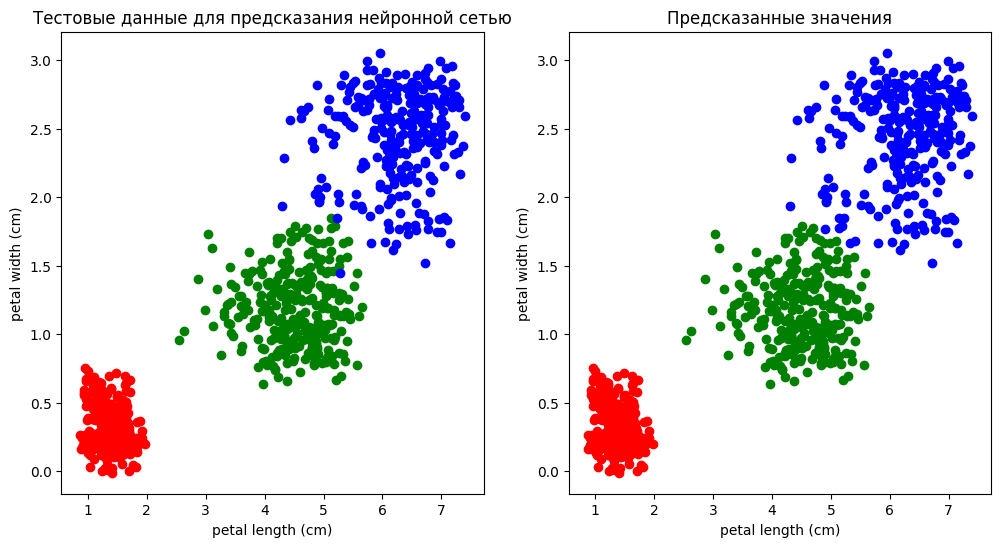

In [13]:
color_dict = {0: 'red', 1: 'green', 2: 'blue'}
plt.figure(figsize=(12, 6))

# Исходные данные
plt.subplot(1, 2, 1)
for idx, true_label in enumerate(test_labels['target']):
    plt.plot(test_data.iloc[idx]['petal length (cm)'], test_data.iloc[idx]['petal width (cm)'], 'o', color=color_dict[true_label])
plt.ylabel('petal width (cm)')
plt.xlabel('petal length (cm)')
plt.title('Тестовые данные для предсказания нейронной сетью')

# Вывод кластеризованных данных
plt.subplot(1, 2, 2)
for idx, pred_label in enumerate(predicted_classes):
    plt.plot(test_data.iloc[idx]['petal length (cm)'], test_data.iloc[idx]['petal width (cm)'], 'o', color=color_dict[pred_label])
plt.ylabel('petal width (cm)')
plt.xlabel('petal length (cm)')
plt.title('Предсказанные значения')

plt.show()

Также графически можно оценить обучение модели

29/29 [==============================] - 0s 2ms/step - loss: 0.0213 - accuracy: 0.9922
Test Accuracy with Dropout: 0.992222249507904


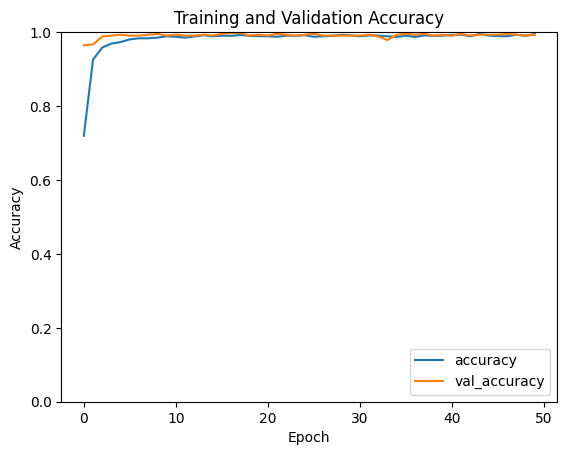

In [14]:
if history is not None:
    # Оценка модели на тестовом наборе данных
    test_loss, test_accuracy = model.evaluate(test_data, test_labels, verbose=1)
    print("Test Accuracy with Dropout:", test_accuracy)

    # Построение кривых обучения и валидации
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.show()
else:
    print("Training history is not available.")

**Заключение**
В данной работе было проведено обучение нейронной сети с помощью библиотеки tensorflow.
Выяснилось какие методы лучше использовать при обработке данных, а так же графически
отображено, как сильно зависит точность модели от исходных данных, и можно сделать вывод, что чем лучше данные кластеризованы, то тем точнее будет модель.

Отмечу что приведение данных к виду, в котором они будут пригодны для работы будет дольше чем построение любой из описанных моделей.